In [1]:
import os
import numpy as np
import rasterio

# Define the folder paths
snow_folder = r"G:/Hangkai/Anttarctic Vegetation Dynamic/Snow/land"
greenness_folder = r"G:/Hangkai/Anttarctic Vegetation Dynamic/Version_2_data/Antarctica_Vegetation_Duration/First_last/Land"
output_folder = r"G:/Hangkai/Anttarctic Vegetation Dynamic/Snow_greenness"

# Ensure the output directory exists
os.makedirs(output_folder, exist_ok=True)

# Loop through each year to process the data
for year in range(2002, 2024):
    snow_file = os.path.join(snow_folder, f"Good_MinSnowCover_{year}.tif")
    greenness_file = os.path.join(greenness_folder, f"Duration_{year}.tif")
    output_file = os.path.join(output_folder, f"SnowGreenness_{year}.tif")

    # Open both the snow cover and greenness duration files
    with rasterio.open(snow_file) as snow_src, rasterio.open(greenness_file) as greenness_src:
        # Check that the spatial dimensions match between the two datasets
        assert snow_src.shape == greenness_src.shape, f"Shape mismatch for year {year}"

        # Read the data
        snow_data = snow_src.read(1)
        greenness_data = greenness_src.read(1)

        # Create masks for snow-free regions and greenness
        snow_free_mask = (snow_data >= 0) & (snow_data <= 30)
        greenness_mask = (greenness_data > 0)

        # Initialize the output array
        output_data = np.zeros_like(snow_data, dtype=np.uint8)

        # Assign values based on the masks
        output_data[snow_free_mask & greenness_mask] = 1  # Greenness in snow-free regions
        output_data[~snow_free_mask & greenness_mask] = 2  # Greenness in snow-covered regions

        # Use the metadata from the snow cover file to write the output
        output_profile = snow_src.profile
        output_profile.update(dtype=rasterio.uint8, count=1, compress='lzw')

        # Save the output data as a new GeoTIFF
        with rasterio.open(output_file, 'w', **output_profile) as dst:
            dst.write(output_data, 1)

print(f"Processing complete. Maps saved to {output_folder}")

Processing complete. Maps saved to G:/Hangkai/Anttarctic Vegetation Dynamic/Snow_greenness



Ratio of Greenness in Snow-Free Regions to Total Greenness (by Year):
2002: 0.410
2003: 0.394
2004: 0.409
2005: 0.419
2006: 0.429
2007: 0.447
2008: 0.399
2009: 0.389
2010: 0.452
2011: 0.415
2012: 0.370
2013: 0.416
2014: 0.392
2015: 0.439
2016: 0.463
2017: 0.397
2018: 0.438
2019: 0.457
2020: 0.438
2021: 0.429
2022: 0.450
2023: 0.410


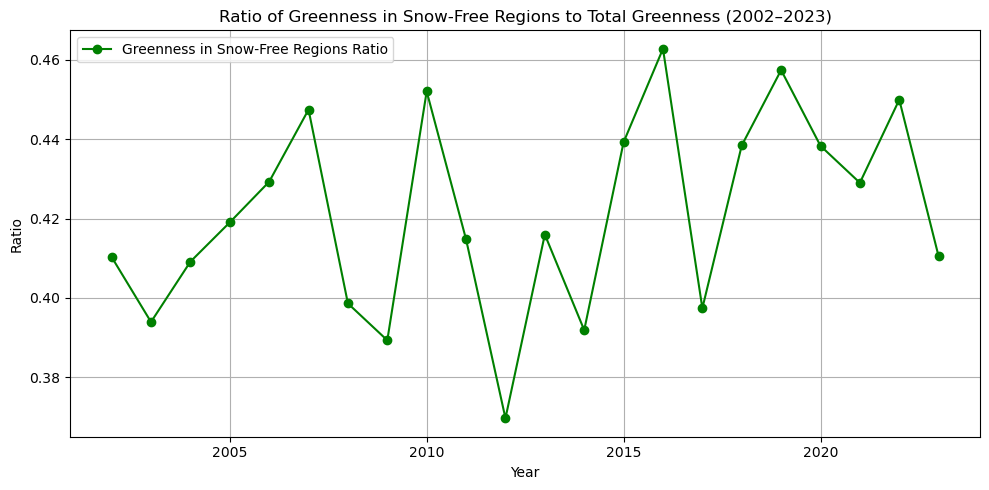

In [2]:
import os
import numpy as np
import rasterio

# Define the folder path containing the output files
output_folder = r"G:/Hangkai/Anttarctic Vegetation Dynamic/Snow_greenness"

# Initialize a dictionary to store the ratio for each year
ratios = {}

# Loop through the output files and calculate the ratio for each year
for year in range(2002, 2024):
    output_file = os.path.join(output_folder, f"SnowGreenness_{year}.tif")
    
    # Open the output GeoTIFF
    with rasterio.open(output_file) as src:
        data = src.read(1)

        # Count the pixels with greenness in snow-free regions (value = 1)
        greenness_snow_free = np.sum(data == 1)

        # Count the total greenness pixels (values = 1 or 2)
        total_greenness = np.sum((data == 1) | (data == 2))

        # Calculate the ratio of greenness in snow-free regions to total greenness
        if total_greenness > 0:
            ratio = greenness_snow_free / total_greenness
        else:
            ratio = 0  # Handle case where no greenness exists

        # Store the ratio for this year
        ratios[year] = ratio

# Display the results
print("\nRatio of Greenness in Snow-Free Regions to Total Greenness (by Year):")
for year, ratio in ratios.items():
    print(f"{year}: {ratio:.3f}")

# Optional: Plot the ratios over the years
import matplotlib.pyplot as plt

years = list(ratios.keys())
values = list(ratios.values())

plt.figure(figsize=(10, 5))
plt.plot(years, values, '-o', color='green', label='Greenness in Snow-Free Regions Ratio')
plt.xlabel('Year')
plt.ylabel('Ratio')
plt.title('Ratio of Greenness in Snow-Free Regions to Total Greenness (2002–2023)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Ratio of Greenness in Snow-Free Regions to Total Greenness by Subregion and Year:
         Ipp-J     Jpp-K       K-A      A-Ap      Ap-B       B-C      C-Cp  \
2002  0.521739  0.157013  0.092593  0.516285  0.070104  0.579216  0.024123   
2003  0.338983  0.297593  0.131455  0.592632  0.074929  0.664634  0.004673   
2004  0.313043  0.265831  0.145205  0.623773  0.076803  0.671815  0.015642   
2005  0.704819  0.317597  0.128205  0.464387  0.113772  0.688615  0.027415   
2006  0.228495  0.176148  0.257143  0.530275  0.116366  0.611185  0.014354   
2007  0.257703  0.267828  0.153488  0.501266  0.131322  0.700000  0.027211   
2008  0.349862  0.213425  0.230769  0.521229  0.071396  0.601683  0.019608   
2009  0.728659  0.278302  0.120513  0.553390  0.082578  0.649083  0.024638   
2010  0.350000  0.191877  0.078880  0.627551  0.140049  0.644444  0.038128   
2011  0.256410  0.314894  0.078091  0.510256  0.082860  0.634454  0.036568   
2012  0.326923  0.288576  0.102510  0.539232  0.081783  0.67

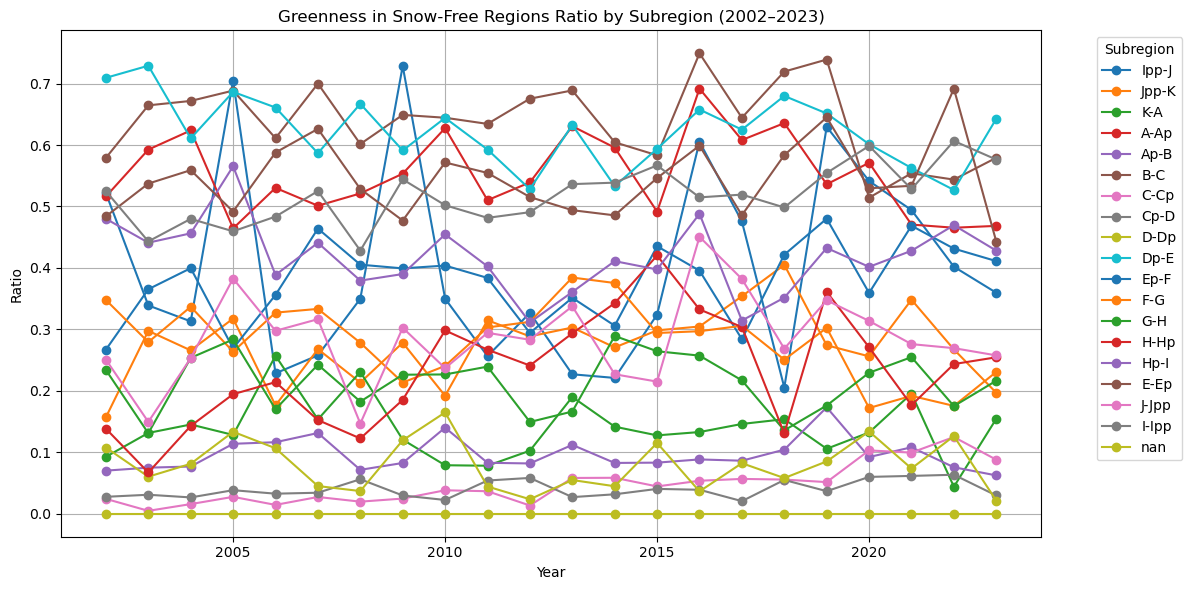

In [11]:
import os
import pandas as pd
import geopandas as gpd

# Define the folder where the shapefiles are stored
shapefile_folder = r"G:/Hangkai/Anttarctic Vegetation Dynamic/Snow_greenness"

# Initialize a dictionary to store ratios by subregion and year
results = {}

# Loop through the shapefiles for each year (2002–2023)
for year in range(2002, 2024):
    shapefile_path = os.path.join(shapefile_folder, f"snow_greenness_{year}.shp")
    
    # Load the shapefile
    gdf = gpd.read_file(shapefile_path)
    
    # Initialize storage for subregion ratios
    year_ratios = {}

    # Loop through each subregion (based on 'Subregion' column or another identifier)
    for subregion in gdf['Subregions'].unique():
        subregion_data = gdf[gdf['Subregions'] == subregion]
        
        # Sum the histogram values for class 1 (greenness in snow-free) and class 2 (greenness with snow)
        greenness_snow_free = subregion_data['HISTO_1'].sum()  # Class 1
        total_greenness = greenness_snow_free + subregion_data['HISTO_2'].sum()  # Classes 1 + 2

        # Calculate the ratio for the subregion
        if total_greenness > 0:
            ratio = greenness_snow_free / total_greenness
        else:
            ratio = 0  # Handle cases with no greenness

        # Store the ratio for this subregion and year
        year_ratios[subregion] = ratio

    # Store the results for this year
    results[year] = year_ratios

# Convert the results dictionary to a DataFrame for easy visualization
df = pd.DataFrame(results).T

# Display the DataFrame
print("Ratio of Greenness in Snow-Free Regions to Total Greenness by Subregion and Year:")
print(df)

# Optional: Save the results to a CSV file
df.to_csv(os.path.join(shapefile_folder, "greenness_snow_free_ratios.csv"))

# Plot the ratios for each subregion over time
df.plot(figsize=(12, 6), marker='o', title="Greenness in Snow-Free Regions Ratio by Subregion (2002–2023)")
plt.xlabel("Year")
plt.ylabel("Ratio")
plt.legend(title="Subregion", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Mean Ratio of Greenness in Snow-Free Regions for Each Subregion:
Ipp-J    0.402807
Jpp-K    0.274892
K-A      0.138303
A-Ap     0.552087
Ap-B     0.095902
B-C      0.638244
C-Cp     0.047233
Cp-D     0.039756
D-Dp     0.079740
Dp-E     0.623417
Ep-F     0.379648
F-G      0.282545
G-H      0.214578
H-Hp     0.234251
Hp-I     0.417896
E-Ep     0.544143
J-Jpp    0.284507
I-Ipp    0.518284
NaN      0.000000
dtype: float64


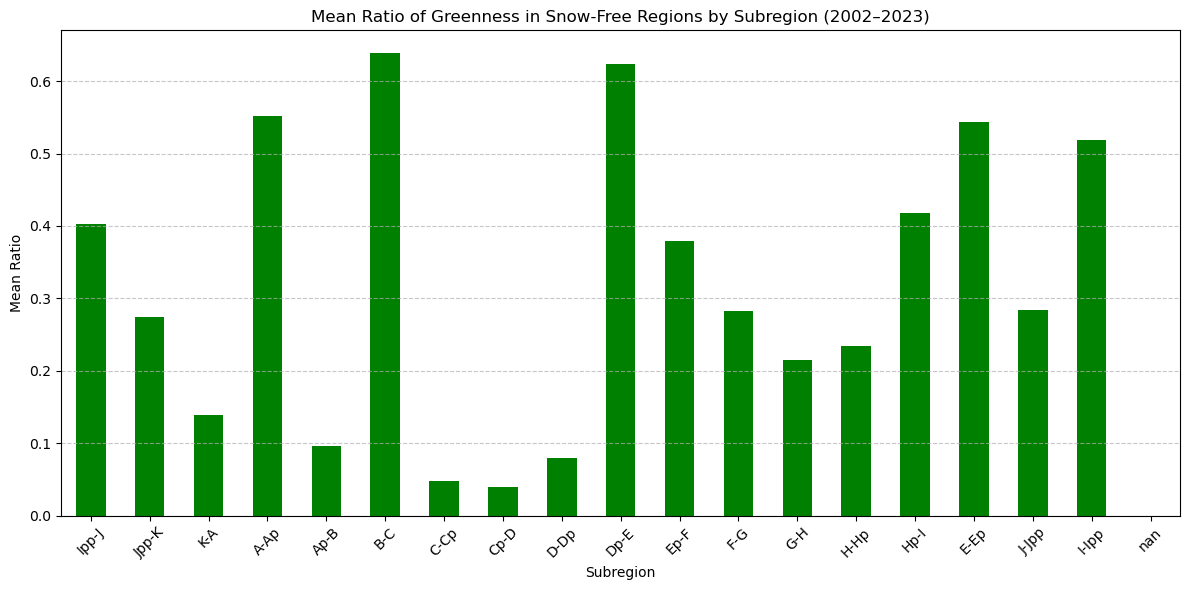

In [14]:
# Calculate the mean ratio for each subregion across all years
mean_ratios = df.mean()

# Display the mean ratios
print("Mean Ratio of Greenness in Snow-Free Regions for Each Subregion:")
print(mean_ratios)

# Optional: Plot the mean ratios
mean_ratios.plot(kind='bar', figsize=(12, 6), color='green')
plt.title('Mean Ratio of Greenness in Snow-Free Regions by Subregion (2002–2023)')
plt.xlabel('Subregion')
plt.ylabel('Mean Ratio')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

C:\Users\hyou34\AppData\Local\Temp\ipykernel_30408\3949187126.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  turbo_colormap = cm.get_cmap('turbo', len(subregion_names))


Skipping A-Ap_data.csv due to missing year information.
Skipping Ap-B_data.csv due to missing year information.
Skipping B-C_data.csv due to missing year information.
Skipping C-Cp_data.csv due to missing year information.
Skipping Cp-D_data.csv due to missing year information.
Skipping D-Dp_data.csv due to missing year information.
Skipping Dp-E_data.csv due to missing year information.
Skipping E-Ep_data.csv due to missing year information.
Skipping Ep-F_data.csv due to missing year information.
Skipping F-G_data.csv due to missing year information.
Skipping G-H_data.csv due to missing year information.
Skipping H-Hp_data.csv due to missing year information.
Skipping Hp-I_data.csv due to missing year information.
Skipping I-Ipp_data.csv due to missing year information.
Skipping Ipp-J_data.csv due to missing year information.
Skipping J-Jpp_data.csv due to missing year information.
Skipping Jpp-K_data.csv due to missing year information.
Skipping K-A_data.csv due to missing year infor

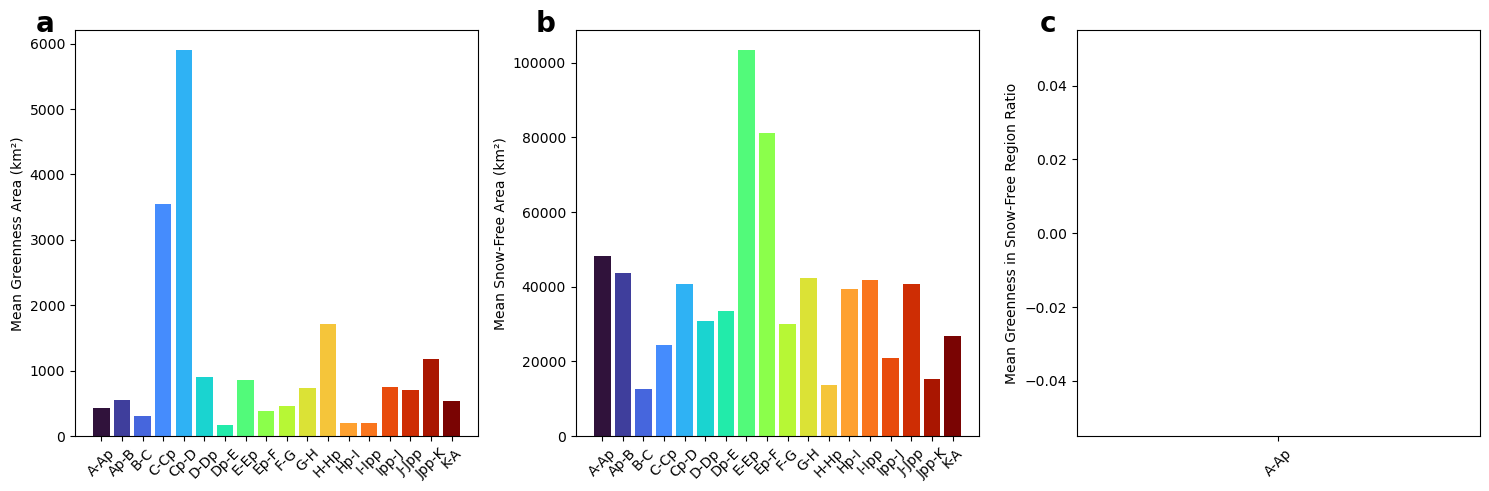

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.cm as cm
import re  # Import regex for robust filename handling

# Define the folder path containing the yearly CSVs with subregion data
folder_path = "G:/Hangkai/Anttarctic Vegetation Dynamic/Subregion_CSVs"

# Define subregion names and Turbo color map
subregion_names = [
    'A-Ap', 'Ap-B', 'B-C', 'C-Cp', 'Cp-D', 'D-Dp', 'Dp-E', 
    'E-Ep', 'Ep-F', 'F-G', 'G-H', 'H-Hp', 'Hp-I', 'I-Ipp', 
    'Ipp-J', 'J-Jpp', 'Jpp-K', 'K-A'
]
turbo_colormap = cm.get_cmap('turbo', len(subregion_names))
subregion_color_dict = {subregion: turbo_colormap(i) for i, subregion in enumerate(subregion_names)}

# Create a DataFrame to store yearly ratios for each subregion
yearly_ratios_df = pd.DataFrame(index=range(2002, 2024), columns=subregion_names)

# Regex pattern to extract the year from the filename
year_pattern = re.compile(r'(\d{4})')

# Loop through the CSV files and compute yearly ratios
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path, index_col=0)

        # Skip files with missing or NaN values
        if df.empty or df[['greenness_area_km2', 'snow_area_below_30_km2']].isna().any().any():
            print(f"Skipping {file_name} due to NaN values or missing data.")
            continue

        # Extract the subregion name and year from the filename
        subregion = file_name[:-4]
        match = year_pattern.search(file_name)
        
        if not match:
            print(f"Skipping {file_name} due to missing year information.")
            continue
        
        year = int(match.group(0))  # Extract the year

        # Calculate the yearly ratio
        greenness_area = df['greenness_area_km2'].mean()
        snow_free_area = df['snow_area_below_30_km2'].mean()

        ratio = greenness_area / snow_free_area if snow_free_area > 0 else 0

        # Store the ratio in the DataFrame
        yearly_ratios_df.at[year, subregion] = ratio

# Calculate the mean ratio across all years for each subregion
mean_ratios = yearly_ratios_df.mean()

# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Mean Greenness Area by Subregion
axes[0].bar(total_greenness_area.keys(), total_greenness_area.values(), 
            color=[subregion_color_dict[subregion] for subregion in total_greenness_area.keys()])
axes[0].set_ylabel('Mean Greenness Area (km²)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].text(-0.05, 1.05, 'a', transform=axes[0].transAxes, 
             fontsize=20, fontweight='bold', va='top', ha='right')

# Plot 2: Mean Snow-Free Area by Subregion
axes[1].bar(total_snow_below_30_area.keys(), total_snow_below_30_area.values(), 
            color=[subregion_color_dict[subregion] for subregion in total_snow_below_30_area.keys()])
axes[1].set_ylabel('Mean Snow-Free Area (km²)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].text(-0.05, 1.05, 'b', transform=axes[1].transAxes, 
             fontsize=20, fontweight='bold', va='top', ha='right')

# Plot 3: Mean Ratio of Greenness in Snow-Free Regions
axes[2].bar(mean_ratios.index, mean_ratios.values, 
            color=[subregion_color_dict[subregion] for subregion in mean_ratios.index])
axes[2].set_ylabel('Mean Greenness in Snow-Free Region Ratio')
axes[2].tick_params(axis='x', rotation=45)
axes[2].text(-0.05, 1.05, 'c', transform=axes[2].transAxes, 
             fontsize=20, fontweight='bold', va='top', ha='right')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

C:\Users\hyou34\AppData\Local\Temp\ipykernel_30408\1847170123.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  turbo_colormap = cm.get_cmap('turbo', len(subregion_names))


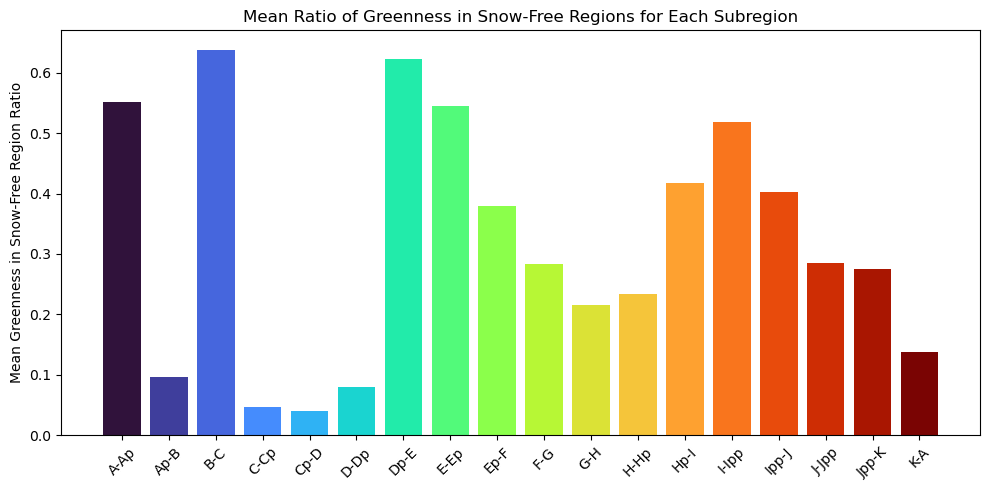

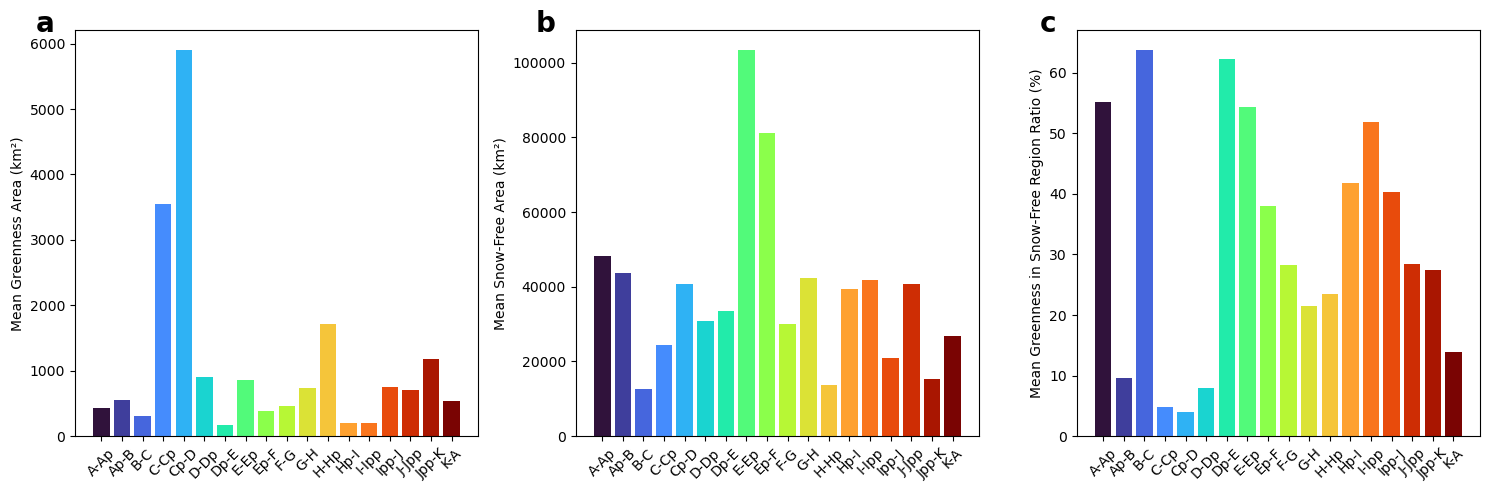

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Define subregion names and Turbo color map
subregion_names = [
    'A-Ap', 'Ap-B', 'B-C', 'C-Cp', 'Cp-D', 'D-Dp', 'Dp-E', 
    'E-Ep', 'Ep-F', 'F-G', 'G-H', 'H-Hp', 'Hp-I', 'I-Ipp', 
    'Ipp-J', 'J-Jpp', 'Jpp-K', 'K-A'
]
turbo_colormap = cm.get_cmap('turbo', len(subregion_names))
subregion_color_dict = {subregion: turbo_colormap(i) for i, subregion in enumerate(subregion_names)}

# New mean ratios data provided
new_mean_ratios = {
    'Ipp-J': 0.402807, 'Jpp-K': 0.274892, 'K-A': 0.138303, 'A-Ap': 0.552087,
    'Ap-B': 0.095902, 'B-C': 0.638244, 'C-Cp': 0.047233, 'Cp-D': 0.039756,
    'D-Dp': 0.079740, 'Dp-E': 0.623417, 'Ep-F': 0.379648, 'F-G': 0.282545,
    'G-H': 0.214578, 'H-Hp': 0.234251, 'Hp-I': 0.417896, 'E-Ep': 0.544143,
    'J-Jpp': 0.284507, 'I-Ipp': 0.518284
}

# Update the mean_ratios to ensure the order of subregions
updated_mean_ratios = pd.Series({k: new_mean_ratios[k] for k in subregion_names})

# Plot the updated Mean Ratio of Greenness in Snow-Free Regions
plt.figure(figsize=(10, 5))
plt.bar(updated_mean_ratios.index, updated_mean_ratios.values, 
        color=[subregion_color_dict[subregion] for subregion in updated_mean_ratios.index])
plt.ylabel('Mean Greenness in Snow-Free Region Ratio')
plt.xticks(rotation=45)
plt.title('Mean Ratio of Greenness in Snow-Free Regions for Each Subregion')
plt.tight_layout()
plt.show()

# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Mean Greenness Area by Subregion
axes[0].bar(total_greenness_area.keys(), total_greenness_area.values(), 
            color=[subregion_color_dict[subregion] for subregion in total_greenness_area.keys()])
axes[0].set_ylabel('Mean Greenness Area (km²)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].text(-0.05, 1.05, 'a', transform=axes[0].transAxes, 
             fontsize=20, fontweight='bold', va='top', ha='right')

# Plot 2: Mean Snow-Free Area by Subregion
axes[1].bar(total_snow_below_30_area.keys(), total_snow_below_30_area.values(), 
            color=[subregion_color_dict[subregion] for subregion in total_snow_below_30_area.keys()])
axes[1].set_ylabel('Mean Snow-Free Area (km²)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].text(-0.05, 1.05, 'b', transform=axes[1].transAxes, 
             fontsize=20, fontweight='bold', va='top', ha='right')

# Plot 3: Mean Ratio of Greenness in Snow-Free Regions
axes[2].bar(updated_mean_ratios.index, updated_mean_ratios.values*100, 
            color=[subregion_color_dict[subregion] for subregion in updated_mean_ratios.index])
axes[2].set_ylabel('Mean Greenness in Snow-Free Region Ratio (%)')
axes[2].tick_params(axis='x', rotation=45)
axes[2].text(-0.05, 1.05, 'c', transform=axes[2].transAxes, 
             fontsize=20, fontweight='bold', va='top', ha='right')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()